# Scout Data Discovery: 311 Service Requests Workflow

This notebook demonstrates a complete workflow for:
1. Discovering 311 service request datasets
2. Assessing their quality using Scout methodology
3. Finding related datasets through relationship analysis
4. Visualizing dataset relationships
5. Generating comprehensive reports

## Overview
311 systems are used by cities to manage non-emergency service requests from residents. These datasets often contain rich information about city services, complaint patterns, and community needs. Using Scout's advanced analysis capabilities, we can discover not only the primary 311 datasets but also related datasets that provide context and additional insights.

In [1]:
# Import required libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add the parent directory to Python path
sys.path.append(str(Path.cwd().parent))

# Import Scout components
from src.scout_discovery import ScoutDataDiscovery
from src.dataset_relationship_graph import DatasetRelationshipGraph
from src.enhanced_api_client import SoQLQueryBuilder

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 All libraries imported successfully!")
print(f"🕒 Workflow started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📚 All libraries imported successfully!
🕒 Workflow started at: 2025-09-13 17:17:45


## Step 1: Initialize Scout Data Discovery

We'll set up Scout with enhanced client capabilities for optimal performance and comprehensive analysis.

In [2]:
# Initialize Scout with enhanced configuration
config = {
    'api': {
        'rate_limit_delay': 1.0,  # Be respectful to the API
        'request_timeout': 45,
        'retry_attempts': 3
    },
    'data': {
        'quality_threshold': 65,  # Lower threshold to find more datasets
        'default_sample_size': 2000  # Larger sample for better analysis
    },
    'cache': {
        'duration_hours': 2  # Cache results for 2 hours
    }
}

# Initialize Scout
scout = ScoutDataDiscovery(
    config=config,
    log_level="INFO",
    use_enhanced_client=True,
    max_workers=3  # Conservative parallelism
)

print("✅ Scout Data Discovery initialized successfully!")
print(f"🔧 Configuration: Quality threshold = {config['data']['quality_threshold']}")
print(f"📊 Sample size: {config['data']['default_sample_size']} rows")

2025-09-13 17:17:46,668 - src.scout_discovery - INFO - Enhanced NYC Data Client initialized with pandas backend
2025-09-13 17:17:46,670 - src.scout_discovery - INFO - Initialized with enhanced API client
2025-09-13 17:17:46,670 - src.scout_discovery - INFO - ScoutDataDiscovery initialized successfully


✅ Scout Data Discovery initialized successfully!
🔧 Configuration: Quality threshold = 65
📊 Sample size: 2000 rows


## Step 2: Discover 311 Service Request Datasets

We'll search for datasets related to 311 service requests using multiple search terms to ensure comprehensive coverage.

In [3]:
# Define search terms for 311 and related service request data
search_terms_311 = [
    "311",
    "service requests", 
    "complaints",
    "311 service requests",
    "non-emergency"
]

print("🔍 Searching for 311 service request datasets...")
print(f"Search terms: {', '.join(search_terms_311)}")

# Perform the search
datasets_311 = scout.search_datasets(
    search_terms=search_terms_311,
    limit=25  # Get up to 25 datasets per search term
)

print(f"\n📋 Found {len(datasets_311)} 311-related datasets")

if not datasets_311.empty:
    print("\n🏆 Top 311 datasets by popularity:")
    top_311 = datasets_311.nlargest(5, 'download_count')
    
    for i, (idx, row) in enumerate(top_311.iterrows(), 1):
        name = row['name'][:70] + '...' if len(row['name']) > 70 else row['name']
        print(f"{i}. {name}")
        print(f"   Downloads: {row['download_count']:,} | Columns: {row.get('columns_count', 'N/A')}")
        print(f"   Updated: {row.get('updatedAt', 'Unknown')[:10]}")
        print()
else:
    print("❌ No 311 datasets found. Trying broader search terms...")

2025-09-13 17:17:49,270 - src.scout_discovery - INFO - Searching for datasets: ['311', 'service requests', 'complaints', '311 service requests', 'non-emergency'] in domains: ['data.cityofnewyork.us']


🔍 Searching for 311 service request datasets...
Search terms: 311, service requests, complaints, 311 service requests, non-emergency


2025-09-13 17:17:55,466 - src.scout_discovery - INFO - Found 63 unique datasets (106 total before deduplication)



📋 Found 63 311-related datasets

🏆 Top 311 datasets by popularity:
1. 311 Service Requests from 2010 to Present
   Downloads: 479,018 | Columns: 51
   Updated: 2025-09-13

2. Hurricane Evacuation Centers (Map)
   Downloads: 230,925 | Columns: 0
   Updated: 2024-09-03

3. DOB Complaints Received
   Downloads: 52,060 | Columns: 15
   Updated: 2025-09-13

4. NYPD Complaint Data Historic
   Downloads: 44,195 | Columns: 44
   Updated: 2025-04-15

5. NYPD Complaint Data Current (Year To Date)
   Downloads: 27,472 | Columns: 45
   Updated: 2025-07-15



## Step 3: Analyze Dataset Structure and Content

Let's examine the structure and content of the most popular 311 dataset to understand what data we're working with.

In [4]:
if not datasets_311.empty:
    # Get the most downloaded dataset for detailed analysis
    primary_dataset = datasets_311.nlargest(1, 'download_count').iloc[0]
    primary_id = primary_dataset['id']
    
    print(f"📊 Analyzing primary dataset: {primary_dataset['name'][:60]}...")
    print(f"Dataset ID: {primary_id}")
    
    # Download a sample for analysis
    print("\n⬇️ Downloading dataset sample...")
    
    try:
        # Use SoQL to get a recent sample
        query = scout.create_query_builder()
        if query:
            # Get recent data and limit columns for performance
            query = query.limit(3000).order_by('created_date', ascending=False)
            sample_df = scout.download_dataset_sample(primary_id, query_builder=query)
        else:
            sample_df = scout.download_dataset_sample(primary_id, sample_size=3000)
        
        if not sample_df.empty:
            print(f"✅ Downloaded sample: {len(sample_df):,} rows × {len(sample_df.columns)} columns")
            
            # Display basic information
            print(f"\n📈 Dataset Overview:")
            print(f"   Shape: {sample_df.shape}")
            print(f"   Memory usage: {sample_df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
            
            # Show column information
            print(f"\n📝 Column Information:")
            for i, col in enumerate(sample_df.columns[:10]):  # Show first 10 columns
                dtype = sample_df[col].dtype
                null_pct = (sample_df[col].isnull().sum() / len(sample_df)) * 100
                unique_vals = sample_df[col].nunique()
                print(f"   {i+1:2d}. {col:<25} | {str(dtype):<12} | {null_pct:5.1f}% null | {unique_vals:,} unique")
            
            if len(sample_df.columns) > 10:
                print(f"   ... and {len(sample_df.columns) - 10} more columns")
            
            # Show sample data
            print(f"\n👀 Sample Data (first 3 rows):")
            display_cols = sample_df.columns[:6]  # Show first 6 columns
            print(sample_df[display_cols].head(3).to_string(index=False))
            
        else:
            print("❌ Dataset appears to be empty or inaccessible")
            sample_df = pd.DataFrame()  # Create empty dataframe for error handling
            
    except Exception as e:
        print(f"❌ Error downloading dataset: {str(e)}")
        sample_df = pd.DataFrame()
else:
    print("⚠️ No datasets available for analysis")
    sample_df = pd.DataFrame()
    primary_id = None

2025-09-13 17:18:11,931 - src.scout_discovery - INFO - Fetching dataset erm2-nwe9 with 2 parameters


📊 Analyzing primary dataset: 311 Service Requests from 2010 to Present...
Dataset ID: erm2-nwe9

⬇️ Downloading dataset sample...


2025-09-13 17:18:12,561 - src.scout_discovery - INFO - Retrieved 3000 rows, 41 columns as pandas DataFrame
2025-09-13 17:18:12,561 - src.scout_discovery - INFO - Downloaded 3000 rows using enhanced client


✅ Downloaded sample: 3,000 rows × 41 columns

📈 Dataset Overview:
   Shape: (3000, 41)
   Memory usage: 6.9 MB

📝 Column Information:
    1. unique_key                | object       |   0.0% null | 3,000 unique
    2. created_date              | object       |   0.0% null | 2,623 unique
    3. agency                    | object       |   0.0% null | 12 unique
    4. agency_name               | object       |   0.0% null | 12 unique
    5. complaint_type            | object       |   0.0% null | 101 unique
    6. descriptor                | object       |   0.0% null | 250 unique
    7. location_type             | object       |   8.9% null | 40 unique
    8. incident_zip              | object       |   0.4% null | 175 unique
    9. incident_address          | object       |   2.2% null | 2,263 unique
   10. street_name               | object       |   2.2% null | 1,251 unique
   ... and 31 more columns

👀 Sample Data (first 3 rows):
unique_key            created_date agency            

## Step 4: Quality Assessment of 311 Datasets

Using Scout's comprehensive quality assessment framework, we'll evaluate the datasets across multiple dimensions.

2025-09-13 17:18:16,037 - src.scout_discovery - INFO - Assessing quality for dataset erm2-nwe9
2025-09-13 17:18:16,039 - src.scout_discovery - INFO - Starting quality assessment for dataset erm2-nwe9
2025-09-13 17:18:16,172 - src.scout_discovery - INFO - Quality assessment completed for erm2-nwe9. Overall score: 88.03


🔍 Performing quality assessment on 311 datasets...

📊 Assessing primary dataset quality: 311 Service Requests from 2010 to Present...

🏆 Quality Assessment Results:
   Overall Score: 88.0/100 (Grade: B)
   📈 Breakdown:
      Completeness:  73.0/100
      Consistency:   92.7/100
      Accuracy:      100.0/100
      Timeliness:    75.0/100
      Usability:     100.0/100

💡 Key Insights:
   Missing data: 27.0%
   Complete columns: 12
   Partially complete: 0


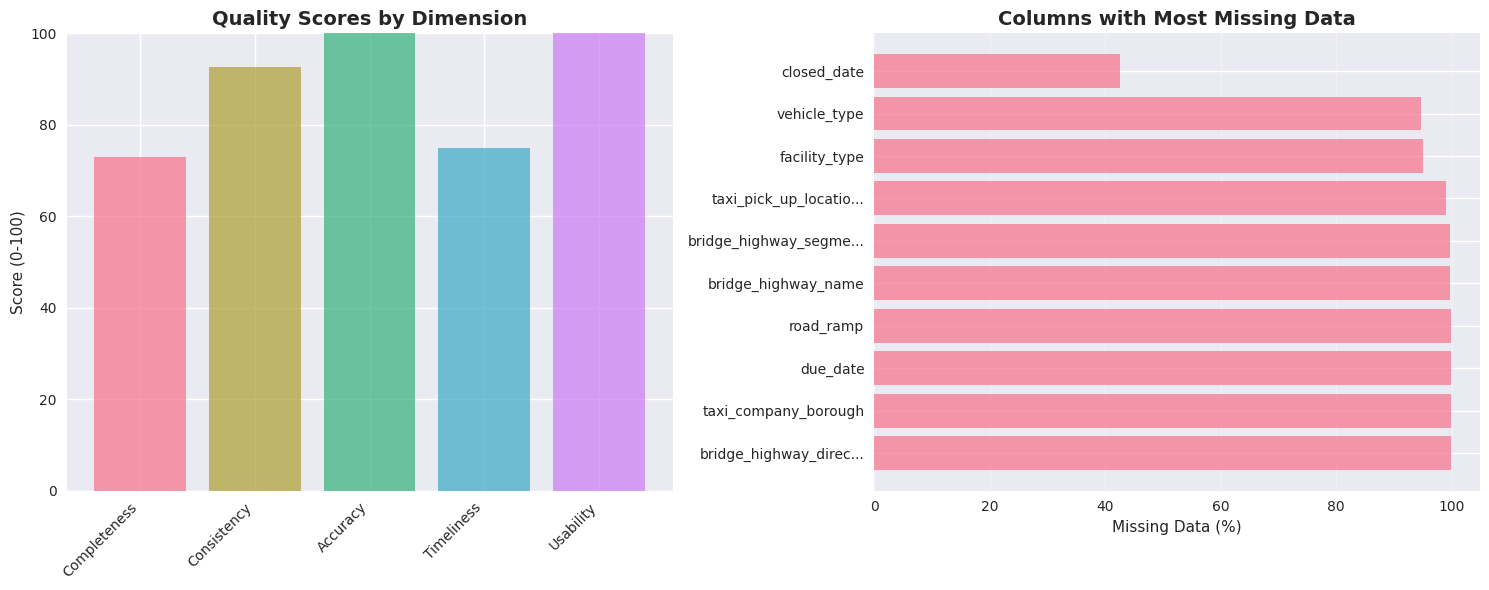

2025-09-13 17:18:16,443 - src.scout_discovery - INFO - Fetching dataset ayer-cga7 with 1 parameters
2025-09-13 17:18:16,624 - src.scout_discovery - INFO - Retrieved 70 rows, 0 columns as pandas DataFrame
2025-09-13 17:18:16,624 - src.scout_discovery - INFO - Downloaded 70 rows using enhanced client
2025-09-13 17:18:16,625 - src.scout_discovery - WARNING - Cannot assess quality: dataset ayer-cga7 is empty
2025-09-13 17:18:16,626 - src.scout_discovery - INFO - Fetching dataset eabe-havv with 1 parameters



🔄 Assessing quality of top 5 datasets for comparison...
   1. Assessing: 311 Service Requests from 2010 to Presen...
      Score: 88.0/100 (B)
   2. Assessing: Hurricane Evacuation Centers (Map)
      ❌ Assessment failed: Dataset is empty...
   3. Assessing: DOB Complaints Received


2025-09-13 17:18:17,849 - src.scout_discovery - INFO - Retrieved 2000 rows, 15 columns as pandas DataFrame
2025-09-13 17:18:17,850 - src.scout_discovery - INFO - Downloaded 2000 rows using enhanced client
2025-09-13 17:18:17,850 - src.scout_discovery - INFO - Assessing quality for dataset eabe-havv
2025-09-13 17:18:17,851 - src.scout_discovery - INFO - Starting quality assessment for dataset eabe-havv
2025-09-13 17:18:17,891 - src.scout_discovery - INFO - Quality assessment completed for eabe-havv. Overall score: 94.54
2025-09-13 17:18:17,892 - src.scout_discovery - INFO - Fetching dataset qgea-i56i with 1 parameters


      Score: 94.5/100 (A)
   4. Assessing: NYPD Complaint Data Historic


2025-09-13 17:18:33,121 - src.scout_discovery - INFO - Retrieved 2000 rows, 40 columns as pandas DataFrame
2025-09-13 17:18:33,121 - src.scout_discovery - INFO - Downloaded 2000 rows using enhanced client
2025-09-13 17:18:33,122 - src.scout_discovery - INFO - Assessing quality for dataset qgea-i56i
2025-09-13 17:18:33,123 - src.scout_discovery - INFO - Starting quality assessment for dataset qgea-i56i
2025-09-13 17:18:33,224 - src.scout_discovery - INFO - Quality assessment completed for qgea-i56i. Overall score: 95.03
2025-09-13 17:18:33,226 - src.scout_discovery - INFO - Fetching dataset 5uac-w243 with 1 parameters


      Score: 95.0/100 (A)
   5. Assessing: NYPD Complaint Data Current (Year To Dat...


2025-09-13 17:18:33,779 - src.scout_discovery - INFO - Retrieved 2000 rows, 41 columns as pandas DataFrame
2025-09-13 17:18:33,780 - src.scout_discovery - INFO - Downloaded 2000 rows using enhanced client
2025-09-13 17:18:33,780 - src.scout_discovery - INFO - Assessing quality for dataset 5uac-w243
2025-09-13 17:18:33,781 - src.scout_discovery - INFO - Starting quality assessment for dataset 5uac-w243
2025-09-13 17:18:33,887 - src.scout_discovery - INFO - Quality assessment completed for 5uac-w243. Overall score: 95.05


      Score: 95.1/100 (A)

📊 Quality Comparison Summary:
                                       name     score grade  download_count
311 Service Requests from 2010 to Presen... 88.032520     B          479018
                    DOB Complaints Received 94.537500     A           52060
               NYPD Complaint Data Historic 95.027812     A           44195
NYPD Complaint Data Current (Year To Dat... 95.051220     A           27472

🥇 Highest Quality Dataset:
   NYPD Complaint Data Current (Year To Dat... (Score: 95.1/100)


In [5]:
if not datasets_311.empty and not sample_df.empty:
    print("🔍 Performing quality assessment on 311 datasets...")
    
    # Assess quality of primary dataset
    print(f"\n📊 Assessing primary dataset quality: {primary_dataset['name'][:50]}...")
    
    quality_assessment = scout.assess_dataset_quality(
        dataset_id=primary_id,
        df=sample_df,
        metadata=primary_dataset.to_dict()
    )
    
    if 'error' not in quality_assessment:
        scores = quality_assessment['overall_scores']
        print(f"\n🏆 Quality Assessment Results:")
        print(f"   Overall Score: {scores['total_score']:.1f}/100 (Grade: {scores['grade']})")
        print(f"   📈 Breakdown:")
        print(f"      Completeness:  {scores['completeness_score']:.1f}/100")
        print(f"      Consistency:   {scores['consistency_score']:.1f}/100")
        print(f"      Accuracy:      {scores['accuracy_score']:.1f}/100")
        print(f"      Timeliness:    {scores['timeliness_score']:.1f}/100")
        print(f"      Usability:     {scores['usability_score']:.1f}/100")
        
        # Show key insights
        completeness = quality_assessment.get('completeness', {})
        print(f"\n💡 Key Insights:")
        print(f"   Missing data: {completeness.get('missing_percentage', 0):.1f}%")
        print(f"   Complete columns: {len(completeness.get('complete_columns', []))}")
        print(f"   Partially complete: {len(completeness.get('partial_columns', []))}")
        
        # Data type recommendations
        consistency = quality_assessment.get('consistency', {})
        type_issues = consistency.get('type_recommendations', {})
        if type_issues:
            print(f"   Data type issues: {len(type_issues)} columns could be optimized")
        
        # Create quality visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Quality scores radar chart
        categories = ['Completeness', 'Consistency', 'Accuracy', 'Timeliness', 'Usability']
        values = [scores['completeness_score'], scores['consistency_score'], 
                 scores['accuracy_score'], scores['timeliness_score'], scores['usability_score']]
        
        ax1.bar(categories, values, alpha=0.7, color=sns.color_palette("husl", len(categories)))
        ax1.set_ylim(0, 100)
        ax1.set_title('Quality Scores by Dimension', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Score (0-100)')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # Missing data visualization
        if not sample_df.empty:
            missing_pct = (sample_df.isnull().sum() / len(sample_df) * 100).sort_values(ascending=False)
            top_missing = missing_pct.head(10)
            
            if not top_missing.empty and top_missing.max() > 0:
                ax2.barh(range(len(top_missing)), top_missing.values, alpha=0.7)
                ax2.set_yticks(range(len(top_missing)))
                ax2.set_yticklabels([col[:20] + '...' if len(col) > 20 else col for col in top_missing.index])
                ax2.set_xlabel('Missing Data (%)')
                ax2.set_title('Columns with Most Missing Data', fontsize=14, fontweight='bold')
                ax2.grid(axis='x', alpha=0.3)
            else:
                ax2.text(0.5, 0.5, 'No significant missing data\nfound in sample', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title('Missing Data Analysis', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"❌ Quality assessment failed: {quality_assessment['error']}")
        quality_assessment = None
        
    # Batch assess multiple datasets for comparison
    print(f"\n🔄 Assessing quality of top 5 datasets for comparison...")
    top_datasets = datasets_311.nlargest(5, 'download_count')
    
    quality_results = []
    for idx, (_, dataset) in enumerate(top_datasets.iterrows()):
        dataset_id = dataset['id']
        dataset_name = dataset['name'][:40] + '...' if len(dataset['name']) > 40 else dataset['name']
        
        print(f"   {idx + 1}. Assessing: {dataset_name}")
        
        try:
            if dataset_id == primary_id and quality_assessment:
                # Use already computed assessment
                assessment = quality_assessment
            else:
                # Assess new dataset
                assessment = scout.assess_dataset_quality(dataset_id)
            
            if 'error' not in assessment:
                overall_score = assessment['overall_scores']['total_score']
                quality_results.append({
                    'name': dataset_name,
                    'id': dataset_id,
                    'score': overall_score,
                    'grade': assessment['overall_scores']['grade'],
                    'download_count': dataset['download_count']
                })
                print(f"      Score: {overall_score:.1f}/100 ({assessment['overall_scores']['grade']})")
            else:
                print(f"      ❌ Assessment failed: {assessment['error'][:50]}...")
                
        except Exception as e:
            print(f"      ❌ Error: {str(e)[:50]}...")
    
    # Show quality comparison
    if quality_results:
        quality_df = pd.DataFrame(quality_results)
        print(f"\n📊 Quality Comparison Summary:")
        print(quality_df[['name', 'score', 'grade', 'download_count']].to_string(index=False))
        
        # Best quality dataset
        best_quality = quality_df.loc[quality_df['score'].idxmax()]
        print(f"\n🥇 Highest Quality Dataset:")
        print(f"   {best_quality['name']} (Score: {best_quality['score']:.1f}/100)")
    
else:
    print("⚠️ Skipping quality assessment - no datasets or data available")
    quality_results = []

## Step 5: Expand Search to Find Related Datasets

Now we'll search for datasets that might be related to 311 service requests, including city services, infrastructure, and community data.

In [6]:
# Define broader search terms for related datasets
related_search_terms = [
    "city services",
    "public works",
    "infrastructure",
    "maintenance",
    "inspections",
    "violations",
    "permits",
    "housing",
    "sanitation",
    "noise complaints",
    "street cleaning",
    "water",
    "transportation"
]

print("🔍 Searching for datasets related to city services and infrastructure...")
print(f"Expanded search terms: {', '.join(related_search_terms[:6])}... (and {len(related_search_terms)-6} more)")

# Perform expanded search
related_datasets = scout.search_datasets(
    search_terms=related_search_terms,
    limit=15  # Smaller limit per term since we have many terms
)

print(f"\n📋 Found {len(related_datasets)} potentially related datasets")

# Combine 311 and related datasets
if not datasets_311.empty and not related_datasets.empty:
    all_datasets = pd.concat([datasets_311, related_datasets], ignore_index=True)
    # Remove duplicates based on dataset ID
    all_datasets = all_datasets.drop_duplicates(subset=['id']).reset_index(drop=True)
    print(f"📊 Total unique datasets for analysis: {len(all_datasets)}")
elif not datasets_311.empty:
    all_datasets = datasets_311.copy()
    print(f"📊 Using only 311 datasets: {len(all_datasets)}")
elif not related_datasets.empty:
    all_datasets = related_datasets.copy()
    print(f"📊 Using only related datasets: {len(all_datasets)}")
else:
    all_datasets = pd.DataFrame()
    print("❌ No datasets found for analysis")

if not all_datasets.empty:
    # Show category breakdown
    print(f"\n🏷️ Dataset Categories:")
    categories = all_datasets['domain_category'].value_counts().head(10)
    for category, count in categories.items():
        category_name = category if pd.notna(category) and category else 'Uncategorized'
        print(f"   {category_name}: {count} datasets")
    
    # Show most popular datasets overall
    print(f"\n🔥 Most Popular Datasets (by downloads):")
    top_popular = all_datasets.nlargest(8, 'download_count')
    
    for i, (idx, row) in enumerate(top_popular.iterrows(), 1):
        name = row['name'][:55] + '...' if len(row['name']) > 55 else row['name']
        category = row.get('domain_category', 'Unknown')
        print(f"   {i}. {name}")
        print(f"      Category: {category} | Downloads: {row['download_count']:,}")

2025-09-13 17:18:33,908 - src.scout_discovery - INFO - Searching for datasets: ['city services', 'public works', 'infrastructure', 'maintenance', 'inspections', 'violations', 'permits', 'housing', 'sanitation', 'noise complaints', 'street cleaning', 'water', 'transportation'] in domains: ['data.cityofnewyork.us']


🔍 Searching for datasets related to city services and infrastructure...
Expanded search terms: city services, public works, infrastructure, maintenance, inspections, violations... (and 7 more)


2025-09-13 17:18:48,117 - src.scout_discovery - INFO - Found 165 unique datasets (179 total before deduplication)



📋 Found 165 potentially related datasets
📊 Total unique datasets for analysis: 220

🏷️ Dataset Categories:
   City Government: 60 datasets
   Environment: 39 datasets
   Housing & Development: 29 datasets
   Transportation: 20 datasets
   Education: 14 datasets
   Public Safety: 13 datasets
   Social Services: 12 datasets
   Uncategorized: 10 datasets
   Health: 10 datasets
   Recreation: 7 datasets

🔥 Most Popular Datasets (by downloads):
   1. 311 Service Requests from 2010 to Present
      Category: Social Services | Downloads: 479,018
   2. Hurricane Evacuation Centers (Map)
      Category: Public Safety | Downloads: 230,925
   3. SBS Certified Business List
      Category: Business | Downloads: 189,880
   4. Jobs NYC Postings
      Category: City Government | Downloads: 181,513
   5. DOHMH New York City Restaurant Inspection Results
      Category: Health | Downloads: 110,612
   6. DOB Permit Issuance
      Category: Housing & Development | Downloads: 103,085
   7. Civil Service 

## Step 6: Dataset Relationship Analysis

This is the core of Scout's advanced capabilities - analyzing relationships between datasets using multiple similarity metrics.

In [7]:
if not all_datasets.empty and len(all_datasets) >= 2:
    print("🌐 Initializing Dataset Relationship Analysis...")
    
    # Initialize the relationship graph
    relationship_graph = DatasetRelationshipGraph()
    
    # Add all datasets to the graph
    relationship_graph.add_datasets(all_datasets)
    
    print(f"✅ Added {len(all_datasets)} datasets to relationship graph")
    
    # Calculate relationships with emphasis on content and structural similarity
    print("\n🔗 Calculating dataset relationships...")
    print("This may take a moment as we analyze content, structure, and metadata patterns...")
    
    relationship_stats = relationship_graph.calculate_relationships(
        content_weight=0.35,        # High weight for content similarity
        structural_weight=0.25,     # Structure matters for data integration
        metadata_weight=0.2,        # Usage patterns and update frequency
        tag_weight=0.15,            # Tag overlap
        category_weight=0.05,       # Category matching
        similarity_threshold=0.2    # Lower threshold to capture more relationships
    )
    
    print(f"\n📊 Relationship Analysis Results:")
    print(f"   Datasets Analyzed: {relationship_stats['datasets_analyzed']}")
    print(f"   Relationships Found: {relationship_stats['relationships_found']}")
    print(f"   Graph Density: {relationship_stats['graph_density']:.3f}")
    print(f"   Connected Components: {relationship_stats['connected_components']}")
    if relationship_stats['relationships_found'] > 0:
        print(f"   Average Clustering: {relationship_stats['average_clustering']:.3f}")
    
    # Focus on 311 dataset relationships if we found the primary dataset
    if 'primary_id' in locals() and primary_id:
        print(f"\n🎯 Datasets most related to our primary 311 dataset:")
        print(f"Primary dataset: {primary_dataset['name'][:60]}...")
        
        related_to_311 = relationship_graph.get_related_datasets(
            dataset_id=primary_id,
            top_n=8,
            min_similarity=0.15  # Lower threshold to find more connections
        )
        
        if related_to_311:
            print(f"\n🔗 Found {len(related_to_311)} related datasets:")
            
            for i, rel in enumerate(related_to_311, 1):
                name = rel['name'][:50] + '...' if len(rel['name']) > 50 else rel['name']
                print(f"\n   {i}. {name}")
                print(f"      Similarity Score: {rel['similarity_score']:.3f}")
                print(f"      Category: {rel.get('category', 'Unknown')}")
                print(f"      Relationship Reasons: {', '.join(rel['relationship_reasons'])}")
                
                # Show similarity breakdown
                breakdown = rel.get('similarity_breakdown', {})
                if breakdown:
                    print(f"      Similarity Breakdown:")
                    for sim_type, score in breakdown.items():
                        if score > 0.1:  # Only show significant similarities
                            sim_name = sim_type.replace('_', ' ').title()
                            print(f"        - {sim_name}: {score:.3f}")
        else:
            print(f"\n🔍 No strong relationships found for the primary 311 dataset.")
            print(f"This might indicate it's quite unique or we need to adjust similarity thresholds.")
    
    # Show overall strongest relationships in the graph
    if relationship_stats['relationships_found'] > 0:
        print(f"\n🏆 Strongest Overall Dataset Relationships:")
        
        # Get all edges and sort by weight
        all_relationships = []
        for edge in relationship_graph.graph.edges(data=True):
            node1, node2, data = edge
            meta1 = relationship_graph.datasets_metadata.get(node1, {})
            meta2 = relationship_graph.datasets_metadata.get(node2, {})
            
            all_relationships.append({
                'dataset1': meta1.get('name', 'Unknown')[:40],
                'dataset2': meta2.get('name', 'Unknown')[:40],
                'similarity': data.get('weight', 0),
                'reasons': data.get('relationship_reasons', [])
            })
        
        # Sort by similarity and show top relationships
        all_relationships.sort(key=lambda x: x['similarity'], reverse=True)
        
        for i, rel in enumerate(all_relationships[:5], 1):
            print(f"\n   {i}. {rel['dataset1']}... ↔ {rel['dataset2']}...")
            print(f"      Similarity: {rel['similarity']:.3f}")
            print(f"      Reasons: {', '.join(rel['reasons'])}")
    
else:
    print("⚠️ Not enough datasets for relationship analysis (need at least 2)")
    relationship_graph = None
    relationship_stats = None

🌐 Initializing Dataset Relationship Analysis...
✅ Added 220 datasets to relationship graph

🔗 Calculating dataset relationships...
This may take a moment as we analyze content, structure, and metadata patterns...

📊 Relationship Analysis Results:
   Datasets Analyzed: 220
   Relationships Found: 10361
   Graph Density: 0.430
   Connected Components: 1
   Average Clustering: 0.670

🎯 Datasets most related to our primary 311 dataset:
Primary dataset: 311 Service Requests from 2010 to Present...

🔗 Found 8 related datasets:

   1. 311 Service Requests for 2004
      Similarity Score: 0.559
      Category: Social Services
      Relationship Reasons: Similar data structure and columns, Similar usage patterns and metadata, Same domain category
      Similarity Breakdown:
        - Content: 0.429
        - Structural: 0.806
        - Metadata: 0.600
        - Tag: 0.250
        - Category: 1.000

   2. 311 Service Requests for 2008
      Similarity Score: 0.558
      Category: Social Services

## Step 7: Create Visualizations

We'll create both static and interactive visualizations to explore the dataset relationships visually.

🎨 Creating relationship visualizations...

📊 Generating static network graph...
✅ Static visualization saved to: 311_dataset_network.png

🌐 Generating interactive network graph...


Failed to create interactive graph: Invalid property specified for object of type plotly.graph_objs.scatter.marker.ColorBar: 'titleside'

Did you mean "title"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has

⚠️ Interactive visualization not available (plotly may not be installed)

📈 Creating additional analysis charts...


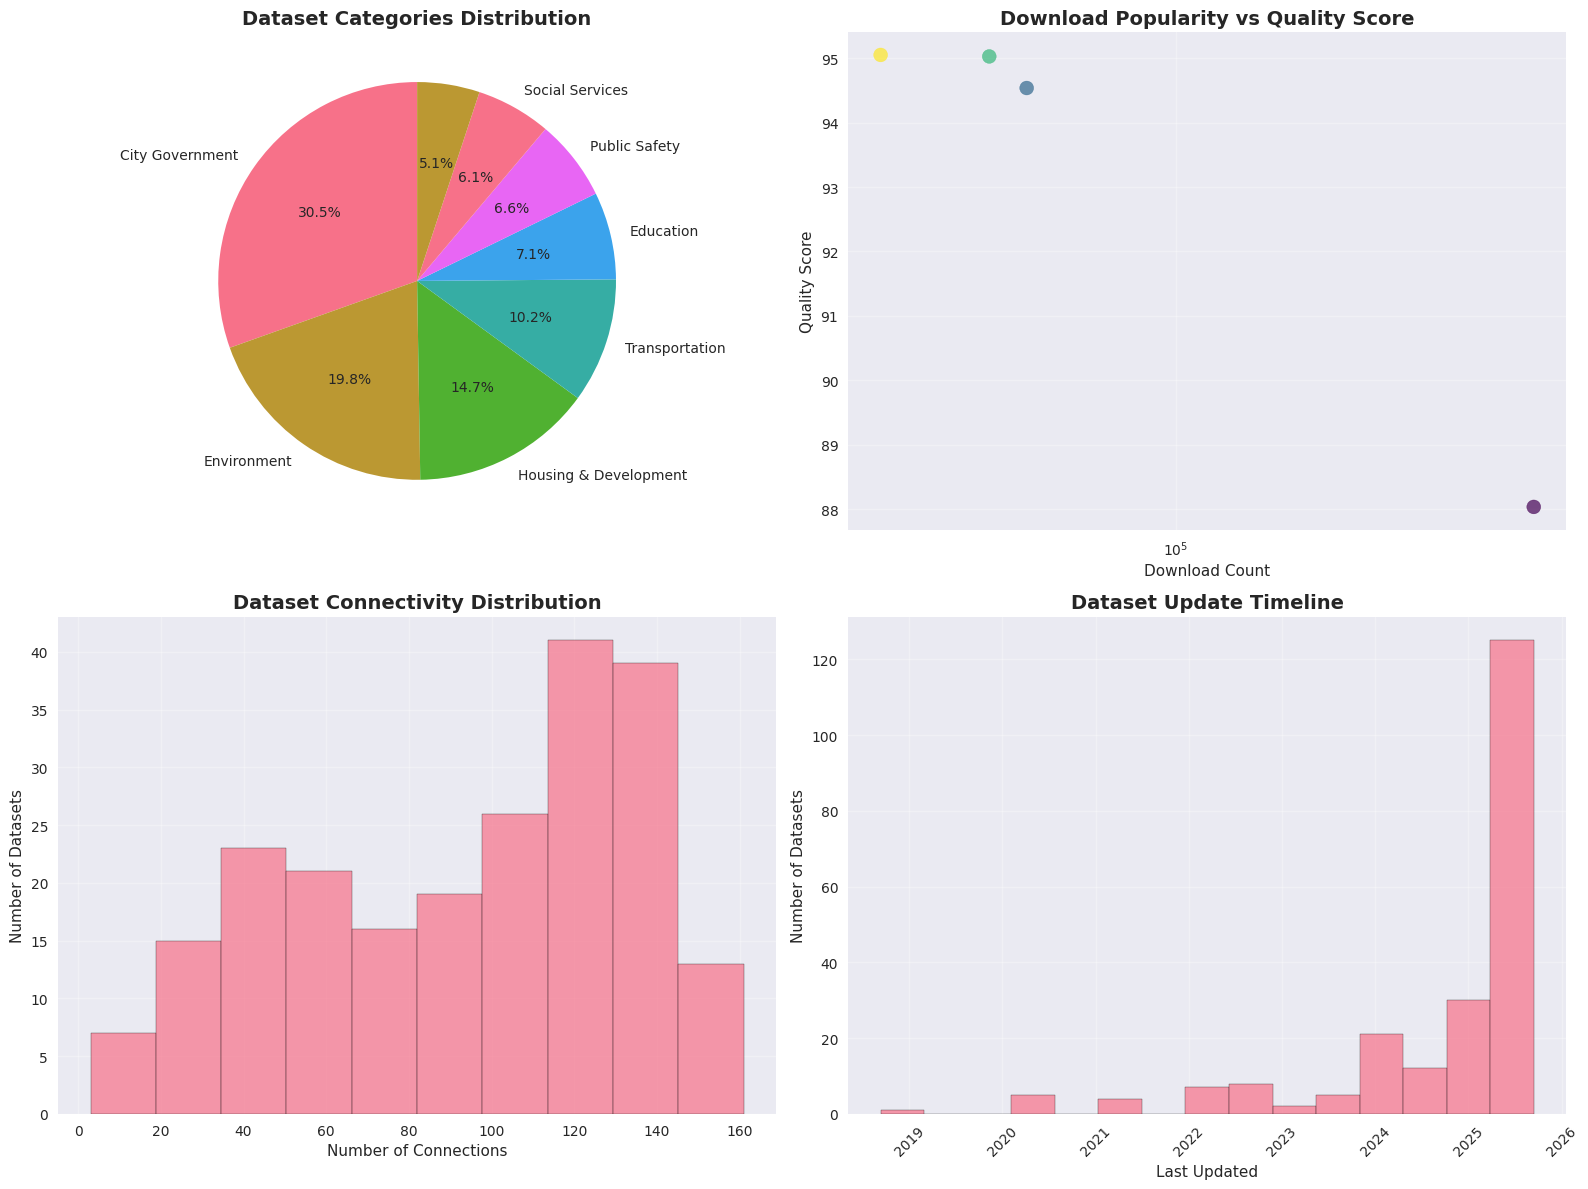

In [8]:
if relationship_graph and relationship_stats and relationship_stats['relationships_found'] > 0:
    print("🎨 Creating relationship visualizations...")
    
    # Create static network visualization
    print("\n📊 Generating static network graph...")
    
    try:
        # Create the visualization
        viz_path = relationship_graph.visualize_graph(
            output_path="311_dataset_network.png",
            layout='spring',
            node_size_by='download_count',
            show_labels=True,
            figsize=(16, 12)
        )
        
        if viz_path:
            print(f"✅ Static visualization saved to: {viz_path}")
        
    except Exception as e:
        print(f"❌ Failed to create static visualization: {str(e)}")
    
    # Create interactive visualization if plotly is available
    print("\n🌐 Generating interactive network graph...")
    
    try:
        interactive_path = relationship_graph.create_interactive_graph(
            output_path="311_interactive_network.html",
            height=700
        )
        
        if interactive_path:
            print(f"✅ Interactive visualization saved to: {interactive_path}")
            print(f"   Open this file in a web browser to explore the network interactively!")
        else:
            print(f"⚠️ Interactive visualization not available (plotly may not be installed)")
            
    except Exception as e:
        print(f"❌ Failed to create interactive visualization: {str(e)}")
    
    # Create additional analysis visualizations
    print("\n📈 Creating additional analysis charts...")
    
    # Dataset categories and relationships
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Category distribution
    categories = all_datasets['domain_category'].fillna('Uncategorized').value_counts().head(8)
    ax1.pie(categories.values, labels=categories.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Dataset Categories Distribution', fontsize=14, fontweight='bold')
    
    # 2. Download counts vs quality scores (if we have quality data)
    if 'quality_results' in locals() and quality_results:
        quality_df = pd.DataFrame(quality_results)
        ax2.scatter(quality_df['download_count'], quality_df['score'], 
                   alpha=0.7, s=100, c=range(len(quality_df)), cmap='viridis')
        ax2.set_xlabel('Download Count')
        ax2.set_ylabel('Quality Score')
        ax2.set_title('Download Popularity vs Quality Score', fontsize=14, fontweight='bold')
        ax2.set_xscale('log')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Quality vs Popularity\nAnalysis Not Available', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Quality vs Popularity Analysis', fontsize=14, fontweight='bold')
    
    # 3. Network connectivity distribution
    if relationship_graph.graph.number_of_nodes() > 0:
        degrees = [relationship_graph.graph.degree(node) for node in relationship_graph.graph.nodes()]
        ax3.hist(degrees, bins=min(10, max(degrees)+1), alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Number of Connections')
        ax3.set_ylabel('Number of Datasets')
        ax3.set_title('Dataset Connectivity Distribution', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No Network\nConnections Found', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Network Connectivity', fontsize=14, fontweight='bold')
    
    # 4. Timeline of dataset updates
    update_dates = pd.to_datetime(all_datasets['updatedAt'], errors='coerce')
    valid_dates = update_dates.dropna()
    
    if not valid_dates.empty:
        ax4.hist(valid_dates, bins=15, alpha=0.7, edgecolor='black')
        ax4.set_xlabel('Last Updated')
        ax4.set_ylabel('Number of Datasets')
        ax4.set_title('Dataset Update Timeline', fontsize=14, fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Update Timeline\nData Not Available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Dataset Update Timeline', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Skipping visualizations - no relationships found or insufficient data")

## Step 8: Generate Comprehensive Reports

Finally, we'll generate detailed reports that can be saved and shared with stakeholders.

In [9]:
print("📄 Generating comprehensive analysis reports...")

# Generate relationship report if we have relationship data
if relationship_graph and relationship_stats and relationship_stats['relationships_found'] > 0:
    print("\n📊 Generating relationship analysis report...")
    
    try:
        relationship_report = relationship_graph.generate_relationship_report(
            output_path="311_relationship_analysis_report.txt"
        )
        
        print(f"✅ Relationship report saved to: 311_relationship_analysis_report.txt")
        
        # Show a sample of the report
        print(f"\n📋 Report Preview:")
        print("-" * 60)
        report_lines = relationship_report.split('\n')[:20]
        for line in report_lines:
            print(line)
        print("...")
        print("-" * 60)
        
    except Exception as e:
        print(f"❌ Failed to generate relationship report: {str(e)}")

# Generate overall summary report
print("\n📝 Generating workflow summary report...")

summary_lines = []
summary_lines.append("SCOUT DATA DISCOVERY - 311 WORKFLOW ANALYSIS SUMMARY")
summary_lines.append("=" * 60)
summary_lines.append(f"Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary_lines.append("")

# Dataset discovery summary
summary_lines.append("DATASET DISCOVERY")
summary_lines.append("-" * 20)
if not datasets_311.empty:
    summary_lines.append(f"311 Datasets Found: {len(datasets_311)}")
    top_311_name = datasets_311.nlargest(1, 'download_count').iloc[0]['name'][:50]
    summary_lines.append(f"Most Popular 311 Dataset: {top_311_name}...")
else:
    summary_lines.append("311 Datasets Found: 0")

if not all_datasets.empty:
    summary_lines.append(f"Total Related Datasets: {len(all_datasets)}")
    top_categories = all_datasets['domain_category'].value_counts().head(3)
    summary_lines.append(f"Top Categories: {', '.join(top_categories.index[:3])}")
else:
    summary_lines.append("Total Related Datasets: 0")

summary_lines.append("")

# Quality assessment summary
summary_lines.append("QUALITY ASSESSMENT")
summary_lines.append("-" * 20)
if 'quality_results' in locals() and quality_results:
    quality_df = pd.DataFrame(quality_results)
    avg_score = quality_df['score'].mean()
    best_dataset = quality_df.loc[quality_df['score'].idxmax()]
    summary_lines.append(f"Datasets Assessed: {len(quality_results)}")
    summary_lines.append(f"Average Quality Score: {avg_score:.1f}/100")
    summary_lines.append(f"Best Quality Dataset: {best_dataset['name']} ({best_dataset['score']:.1f}/100)")
else:
    summary_lines.append("Quality Assessment: Not completed")

summary_lines.append("")

# Relationship analysis summary
summary_lines.append("RELATIONSHIP ANALYSIS")
summary_lines.append("-" * 20)
if relationship_stats:
    summary_lines.append(f"Datasets in Network: {relationship_stats['datasets_analyzed']}")
    summary_lines.append(f"Relationships Found: {relationship_stats['relationships_found']}")
    summary_lines.append(f"Network Density: {relationship_stats['graph_density']:.3f}")
    summary_lines.append(f"Connected Groups: {relationship_stats['connected_components']}")
    
    if 'related_to_311' in locals() and related_to_311:
        summary_lines.append(f"Datasets Related to Primary 311: {len(related_to_311)}")
        if related_to_311:
            top_related = related_to_311[0]
            summary_lines.append(f"Most Similar Dataset: {top_related['name'][:40]}... ({top_related['similarity_score']:.3f})")
else:
    summary_lines.append("Relationship Analysis: Not completed")

summary_lines.append("")

# Key insights and recommendations
summary_lines.append("KEY INSIGHTS AND RECOMMENDATIONS")
summary_lines.append("-" * 40)

if not datasets_311.empty:
    summary_lines.append("✓ Successfully discovered 311 service request datasets")
    if 'primary_dataset' in locals():
        summary_lines.append(f"✓ Primary dataset identified: {primary_dataset['name'][:40]}...")
        
if relationship_stats and relationship_stats['relationships_found'] > 0:
    summary_lines.append("✓ Found meaningful relationships between datasets")
    summary_lines.append("✓ Network analysis reveals data integration opportunities")
    if 'related_to_311' in locals() and related_to_311:
        summary_lines.append(f"✓ Identified {len(related_to_311)} datasets related to 311 services")
        
        # Recommendations based on relationships
        summary_lines.append("")
        summary_lines.append("INTEGRATION RECOMMENDATIONS:")
        for i, rel in enumerate(related_to_311[:3], 1):
            reason = rel['relationship_reasons'][0] if rel['relationship_reasons'] else 'General similarity'
            summary_lines.append(f"{i}. Consider integrating with {rel['name'][:30]}... ({reason})")
            
if 'quality_results' in locals() and quality_results:
    quality_df = pd.DataFrame(quality_results)
    high_quality = quality_df[quality_df['score'] >= 80]
    if not high_quality.empty:
        summary_lines.append(f"✓ Found {len(high_quality)} high-quality datasets (score ≥ 80)")
        summary_lines.append("✓ These datasets are recommended for production use")

summary_lines.append("")
summary_lines.append("FILES GENERATED:")
files_generated = [
    "311_dataset_network.png (Static network visualization)",
    "311_interactive_network.html (Interactive network visualization)",
    "311_relationship_analysis_report.txt (Detailed relationship report)",
    "scout_311_workflow_summary.txt (This summary report)"
]

for file in files_generated:
    summary_lines.append(f"- {file}")

summary_report = '\n'.join(summary_lines)

# Save summary report
try:
    with open("scout_311_workflow_summary.txt", "w", encoding="utf-8") as f:
        f.write(summary_report)
    print(f"✅ Summary report saved to: scout_311_workflow_summary.txt")
except Exception as e:
    print(f"❌ Failed to save summary report: {str(e)}")

# Display summary in notebook
print(f"\n📋 Workflow Summary:")
print("=" * 50)
for line in summary_lines[3:]:  # Skip the header lines
    if line.strip():
        print(line)
    elif line == "":
        print()
        
# Export graph data for further analysis
if relationship_graph:
    try:
        graph_file = relationship_graph.export_graph_data(
            "311_graph_data.json", 
            format="json"
        )
        print(f"\n💾 Graph data exported to: {graph_file}")
    except Exception as e:
        print(f"❌ Failed to export graph data: {str(e)}")

print(f"\n🎉 Workflow completed successfully!")
print(f"⏰ Total runtime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📄 Generating comprehensive analysis reports...

📊 Generating relationship analysis report...
✅ Relationship report saved to: 311_relationship_analysis_report.txt

📋 Report Preview:
------------------------------------------------------------
DATASET RELATIONSHIP ANALYSIS REPORT
Generated on: 2025-09-13 17:21:38

OVERVIEW
--------------------
Total Datasets: 220
Total Relationships: 10361
Graph Density: 0.430
Connected Components: 1
Average Clustering Coefficient: 0.670

CLUSTER ANALYSIS
--------------------

Cluster 1: 42 datasets
  - 311 Service Requests from 2010 to Present (Social Services)
  - 311 Service Requests for 2009 (Social Services)
  - 311 Service Requests for 2008 (Social Services)
  ... and 39 more
...
------------------------------------------------------------

📝 Generating workflow summary report...
✅ Summary report saved to: scout_311_workflow_summary.txt

📋 Workflow Summary:

DATASET DISCOVERY
--------------------
311 Datasets Found: 63
Most Popular 311 Dataset: 311

## Next Steps and Recommendations

Based on this analysis, here are recommended next steps:

### For Data Integration
1. **Focus on High-Similarity Datasets**: Use the datasets with similarity scores > 0.4 for integration projects
2. **Leverage Structural Similarities**: Datasets with similar column structures can be more easily combined
3. **Consider Temporal Alignment**: Check update frequencies to ensure data freshness alignment

### For Analysis Projects
1. **Cross-Reference Service Requests**: Use related datasets to provide context for 311 complaints
2. **Identify Service Gaps**: Compare 311 requests with available city services data
3. **Geographic Analysis**: Combine with location-based datasets for spatial analysis

### For Data Quality Improvement
1. **Address Missing Data**: Focus on datasets with completeness scores < 70
2. **Standardize Data Types**: Implement recommendations from consistency analysis
3. **Regular Quality Monitoring**: Set up automated quality checks using Scout

### For Ongoing Discovery
1. **Monitor New Datasets**: Regularly run this workflow to identify new related datasets
2. **Expand Search Terms**: Add domain-specific terms as you learn more about the data landscape
3. **Community Engagement**: Use insights to identify data needs and gaps

---

*This notebook demonstrates the power of Scout's comprehensive data discovery and relationship analysis capabilities. The generated reports and visualizations provide actionable insights for data-driven decision making.*